In [10]:
%load_ext autoreload
%autoreload 2
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit,KFold,GridSearchCV
from sklearn.metrics import accuracy_score,fbeta_score,f1_score
import numpy as np
import matplotlib.pyplot as plt
from helpers import make_complexity_curve, make_learning_curve,make_timing_curve,make_timing_curve_fixed
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Load Cleaned Adult Data**

In [2]:
adult_df = pd.read_csv(filepath_or_buffer="adult_cleaned.csv")
adult_df_dummies = pd.get_dummies(adult_df.drop('target', 1))
adult_x = adult_df_dummies.copy().values
adult_y = adult_df["target"].copy().values
X_adult_train, X_adult_test, y_adult_train, y_adult_test = train_test_split(adult_x, adult_y, test_size=0.2,random_state=0)
print(f"adult_df: {adult_df.shape}")
print(f"X_adult_train: {X_adult_train.shape}")
print(f"X_adult_test: {X_adult_test.shape}")
print(f"y_adult_train: {y_adult_train.shape}")
print(f"y_adult_test: {y_adult_test.shape}")
print(f"y_adult_train pos: {(y_adult_train > 0).sum() / len(y_adult_train)}")
print(f"y_adult_train neg: {(y_adult_train == 0).sum() / len(y_adult_train)}")
pipeAdult = Pipeline([('Scale',StandardScaler())])
X_trans_adult_train = pipeAdult.fit_transform(X_adult_train, y_adult_train)
print(f"X_tran_adult_train: {X_trans_adult_train.shape}")

adult_df: (30162, 13)
X_adult_train: (24129, 70)
X_adult_test: (6033, 70)
y_adult_train: (24129,)
y_adult_test: (6033,)
y_adult_train pos: 0.2489535413817398
y_adult_train neg: 0.7510464586182601
X_tran_adult_train: (24129, 70)


**Load Spam**

In [4]:
spam_df = pd.read_csv('spambase2.csv', header=0)
spam_x = spam_df.drop('class', axis=1).copy().values
spam_y = spam_df['class'].copy().values
X_spam_train, X_spam_test, y_spam_train, y_spam_test = train_test_split(spam_x, spam_y, test_size=0.2,random_state=0)
print(f"spam_df: {spam_df.shape}")
print(f"X_spam_train: {X_spam_train.shape}")
print(f"X_spam_test: {X_spam_test.shape}")
print(f"y_spam_train: {y_spam_train.shape}")
print(f"y_spam_test: {y_spam_test.shape}")
print(f"y_spam_train pos: {(y_spam_train > 0).sum() / len(y_spam_train)}")
print(f"y_spam_train neg: {(y_spam_train == 0).sum() / len(y_spam_train)}")
pipeSpam = Pipeline([('Scale',StandardScaler())])
X_trans_spam_train = pipeSpam.fit_transform(X_spam_train, y_spam_train)
print(f"X_tran_spam_train: {X_trans_spam_train.shape}")

spam_df: (4601, 58)
X_spam_train: (3680, 57)
X_spam_test: (921, 57)
y_spam_train: (3680,)
y_spam_test: (921,)
y_spam_train pos: 0.38858695652173914
y_spam_train neg: 0.6114130434782609
X_tran_spam_train: (3680, 57)


In [15]:
def getParams(nFeatures):
    alphas = [10**-x for x in np.arange(-1,5.01,1/2)]
    hiddens = [(h,)*l for l in [1,2,3] for h in [nFeatures,nFeatures//2,nFeatures*2]]
    params = {
        'MLP__activation':['relu','logistic'],
        'MLP__alpha':alphas,
        'MLP__hidden_layer_sizes':hiddens
    }
    return params
adultParams = getParams(X_trans_adult_train.shape[1])
spamParams = getParams(X_trans_spam_train.shape[1])

In [11]:
pipeAdult = Pipeline([
    ('Scale',StandardScaler()),
    ('MLP',MLPClassifier(max_iter=2000,early_stopping=True,random_state=55))
])
adult_cv = GridSearchCV(pipeAdult,param_grid=getParams(X_trans_adult_train.shape[1]), cv=5)
adult_cv.fit(X_trans_adult_train, y_adult_train)
print(f"best params adult: {adult_cv.best_params_}")

best params adult: {'MLP__activation': 'relu', 'MLP__alpha': 1.0, 'MLP__hidden_layer_sizes': (70,)}


In [12]:
pipeSpam = Pipeline([
    ('Scale',StandardScaler()),
    ('MLP',MLPClassifier(max_iter=2000,early_stopping=True,random_state=55))
])
spam_cv = GridSearchCV(pipeSpam,param_grid=getParams(X_trans_spam_train.shape[1]), cv=5)
spam_cv.fit(X_trans_spam_train, y_spam_train)
print(f"best params spam: {spam_cv.best_params_}")

best params spam: {'MLP__activation': 'relu', 'MLP__alpha': 0.00031622776601683794, 'MLP__hidden_layer_sizes': (57, 57, 57)}


**Complexity**

In [17]:
adult_cc_alphas = make_complexity_curve(spam_cv.best_estimator_, X_trans_adult_train.astype(float), y_adult_train.astype(float), "MLP__alpha", adultParams['MLP__alpha'],"ann complexity alphas", "adult")

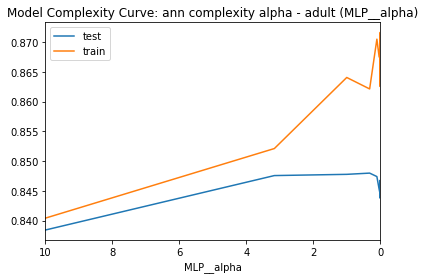

In [18]:
adult_cc_alphas.plot(title=adult_cc_alphas.name)

In [22]:
spam_cc_alphas = make_complexity_curve(spam_cv.best_estimator_, X_trans_spam_train.astype(float), y_spam_train.astype(float), "MLP__alpha", spamParams['MLP__alpha'],"ann complexity alphas", "spam")

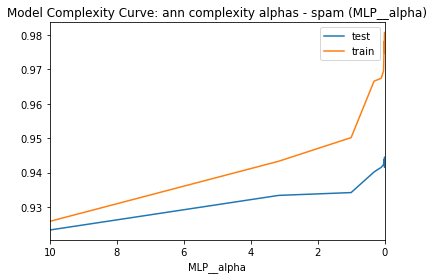

In [23]:
spam_cc_alphas.plot(title=spam_cc_alphas.name)

In [32]:
adult_cc_layers = make_complexity_curve(spam_cv.best_estimator_, X_trans_adult_train.astype(float), y_adult_train.astype(float), "MLP__hidden_layer_sizes", adultParams['MLP__hidden_layer_sizes'],"ann complexity hidden_layer_sizes", "adult")

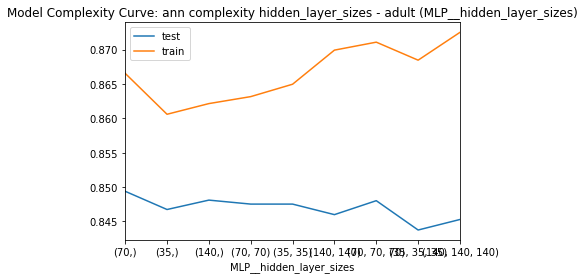

In [33]:
adult_cc_layers.plot(title=adult_cc_layers.name)

In [34]:
spam_cc_layers = make_complexity_curve(spam_cv.best_estimator_, X_trans_spam_train.astype(float), y_spam_train.astype(float), "MLP__hidden_layer_sizes", spamParams['MLP__hidden_layer_sizes'],"ann complexity layers", "spam")

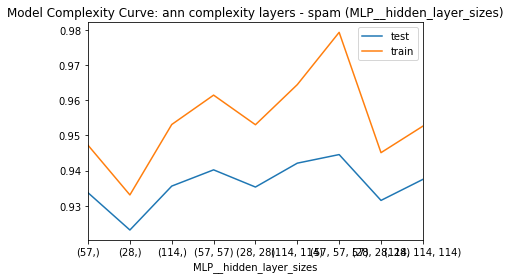

In [35]:
spam_cc_layers.plot(title=spam_cc_layers.name)

**Timing curve**

In [24]:
adult_timing = make_timing_curve(adult_cv.best_estimator_,X_trans_adult_train.astype(float), y_adult_train.astype(float),'ann timing', 'adult')

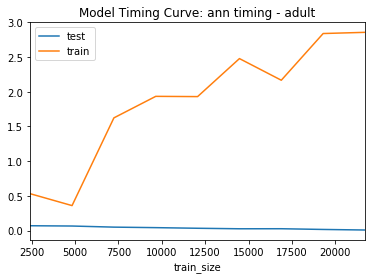

In [25]:
adult_timing.plot(title=adult_timing.name)

In [26]:
spam_timing = make_timing_curve(spam_cv.best_estimator_,X_trans_spam_train.astype(float), y_spam_train.astype(float),'ann timing', 'spam')

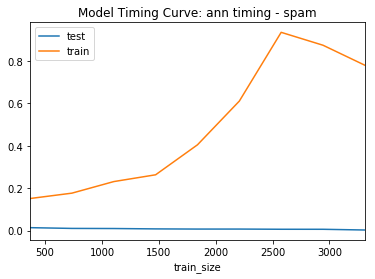

In [27]:
spam_timing.plot(title=spam_timing.name)

**Learning Curve**

In [28]:
adult_lc = make_learning_curve(adult_cv.best_estimator_,X_trans_adult_train.astype(float), y_adult_train.astype(float),np.linspace(0.1, 1.0, 10),'ann timing', 'adult')

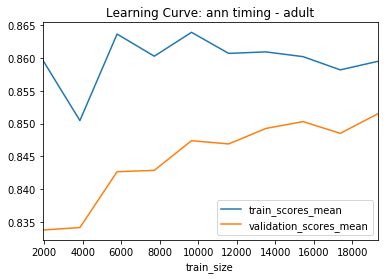

In [29]:
adult_lc.plot(title=adult_lc.name)

In [30]:
spam_lc = make_learning_curve(spam_cv.best_estimator_,X_trans_spam_train.astype(float), y_spam_train.astype(float),np.linspace(0.1, 1.0, 10),'ann timing', 'spam')

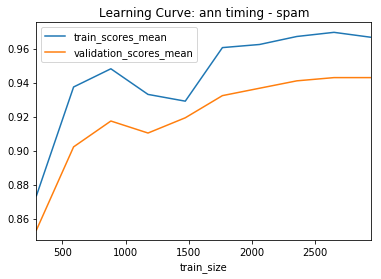

In [31]:
spam_lc.plot(title=spam_lc.name)